In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [113]:
dataset = pd.read_excel("./online_retail_II.xlsx")

In [114]:
dataset.set_index("Customer ID", inplace=True)

In [115]:
dataset["Month"] = dataset["InvoiceDate"].dt.to_period("M")
dataset.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country,Month
Customer ID,,,,,,,,
13085.0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,United Kingdom,2009-12
13085.0,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,2009-12
13085.0,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,2009-12
13085.0,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,United Kingdom,2009-12
13085.0,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,United Kingdom,2009-12


In [116]:
# Total Price
dataset["TotalPrice"] = dataset["Quantity"] * dataset["Price"]

In [117]:
# RFM
reference_date = dataset["InvoiceDate"].max() + pd.Timedelta(days=1)
rfm = dataset.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                     # Frequency
    'TotalPrice': 'mean'                                       # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalPrice': 'Monetary'
})

In [118]:
dataset

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country,Month,TotalPrice
Customer ID,,,,,,,,,
13085.0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,United Kingdom,2009-12,83.40
13085.0,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,2009-12,81.00
13085.0,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,2009-12,81.00
13085.0,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,United Kingdom,2009-12,100.80
13085.0,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,United Kingdom,2009-12,30.00
...,...,...,...,...,...,...,...,...,...
17530.0,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,United Kingdom,2010-12,5.90
17530.0,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,United Kingdom,2010-12,3.75
17530.0,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,United Kingdom,2010-12,3.75


In [119]:
churn_labelled = dataset.groupby('Customer ID')["Month"].unique().reset_index().explode('Month', ignore_index=True)
churn_labelled["Month"] = pd.to_datetime(churn_labelled["Month"].astype(str))
churn_labelled["Churn"] = churn_labelled.groupby("Customer ID")["Month"].diff()
churn_labelled = churn_labelled.groupby("Customer ID")["Churn"].apply(lambda x: 0 if x.max() > pd.Timedelta(days=90) else 1)

In [120]:
# Tenure
tenure = dataset["InvoiceDate"].groupby("Customer ID").agg(["max", "min"])
tenure["tenure"] = (tenure["max"] -  tenure["min"]).dt.days

In [121]:
# Seasonal Trends - Months

seasonal_month = dataset[["InvoiceDate","Month"]].groupby(["Customer ID", "Month"]).count()

In [122]:
seasonal_month

InvoiceDate
Customer ID Month               
12346.0     2009-12            5
            2010-01            5
            2010-03            5
            2010-06           29
            2010-10            2
...                          ...
18286.0     2010-08           50
18287.0     2009-12            1
            2010-05           54
            2010-09           21
            2010-11           10

[13940 rows x 1 columns]

In [123]:
seasonal_month = seasonal_month.rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).groupby("Customer ID")["InvoiceDate"].sum()

In [124]:
# Merge the all dataframes with dataset
rfm = rfm.merge(tenure, left_index=True, right_index=True)
rfm = rfm.merge(seasonal_month, left_index=True, right_index=True)
rfm = rfm.merge(churn_labelled, left_index=True, right_index=True)
rfm = rfm.rename(columns={"InvoiceDate": "MonthlyTrend"})
rfm

,Recency,Frequency,Monetary,max,min,tenure,MonthlyTrend,Churn
Customer ID,,,,,,,,
12346.0,67,15,-1.406087,2010-10-04 16:33:00,2009-12-14 08:34:00,294,-3.0,0
12347.0,3,2,18.638310,2010-12-07 14:57:00,2010-10-31 14:20:00,37,29.0,1
12348.0,74,1,11.108000,2010-09-27 14:59:00,2010-09-27 14:59:00,0,-11.0,1
12349.0,43,4,24.738224,2010-10-28 08:23:00,2009-12-04 12:49:00,327,35.0,0
12351.0,11,1,14.330000,2010-11-29 15:23:00,2010-11-29 15:23:00,0,-34.0,1
...,...,...,...,...,...,...,...,...
18283.0,18,6,2.790304,2010-11-22 15:30:00,2010-02-19 17:16:00,275,49.0,0
18284.0,65,2,15.057931,2010-10-06 12:31:00,2010-10-04 11:33:00,2,-30.0,1
18285.0,296,1,35.583333,2010-02-17 10:24:00,2010-02-17 10:24:00,0,-17.0,1


In [125]:
dataset

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country,Month,TotalPrice
Customer ID,,,,,,,,,
13085.0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,United Kingdom,2009-12,83.40
13085.0,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,2009-12,81.00
13085.0,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,2009-12,81.00
13085.0,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,United Kingdom,2009-12,100.80
13085.0,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,United Kingdom,2009-12,30.00
...,...,...,...,...,...,...,...,...,...
17530.0,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,United Kingdom,2010-12,5.90
17530.0,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,United Kingdom,2010-12,3.75
17530.0,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,United Kingdom,2010-12,3.75


In [126]:
dataset["AOV"] = dataset["TotalPrice"] / dataset["Quantity"]
dataset = dataset[["Quantity", "Price", "TotalPrice", "AOV"]].groupby("Customer ID").mean()

In [127]:
dataset = dataset.merge(rfm, left_index=True, right_index=True)

In [128]:
dataset

,Quantity,Price,TotalPrice,AOV,Recency,Frequency,Monetary,max,min,tenure,MonthlyTrend,Churn
Customer ID,,,,,,,,,,,,
12346.0,1.130435,12.573043,-1.406087,12.573043,67,15,-1.406087,2010-10-04 16:33:00,2009-12-14 08:34:00,294,-3.0,0
12347.0,11.661972,2.295070,18.638310,2.295070,3,2,18.638310,2010-12-07 14:57:00,2010-10-31 14:20:00,37,29.0,1
12348.0,18.650000,0.719500,11.108000,0.719500,74,1,11.108000,2010-09-27 14:59:00,2010-09-27 14:59:00,0,-11.0,1
12349.0,9.233645,8.406449,24.738224,8.406449,43,4,24.738224,2010-10-28 08:23:00,2009-12-04 12:49:00,327,35.0,0
12351.0,12.428571,2.355238,14.330000,2.355238,11,1,14.330000,2010-11-29 15:23:00,2010-11-29 15:23:00,0,-34.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
18283.0,1.460870,2.168783,2.790304,2.168783,18,6,2.790304,2010-11-22 15:30:00,2010-02-19 17:16:00,275,49.0,0
18284.0,17.000000,4.003103,15.057931,4.003103,65,2,15.057931,2010-10-06 12:31:00,2010-10-04 11:33:00,2,-30.0,1
18285.0,12.083333,8.350000,35.583333,8.350000,296,1,35.583333,2010-02-17 10:24:00,2010-02-17 10:24:00,0,-17.0,1


In [129]:
dataset = dataset[["Quantity", "Price", "TotalPrice", "Recency", "Frequency", "Monetary", "tenure", "MonthlyTrend", "AOV", "Churn"]]
dataset.head(10)

,Quantity,Price,TotalPrice,Recency,Frequency,Monetary,tenure,MonthlyTrend,AOV,Churn
Customer ID,,,,,,,,,,
12346.0,1.130435,12.573043,-1.406087,67,15,-1.406087,294,-3.0,12.573043,0
12347.0,11.661972,2.295070,18.638310,3,2,18.638310,37,29.0,2.295070,1
12348.0,18.650000,0.719500,11.108000,74,1,11.108000,0,-11.0,0.719500,1
12349.0,9.233645,8.406449,24.738224,43,4,24.738224,327,35.0,8.406449,0
12351.0,12.428571,2.355238,14.330000,11,1,14.330000,0,-34.0,2.355238,1
12352.0,10.444444,3.033333,19.100000,11,2,19.100000,16,-3.0,3.033333,1
12353.0,9.600000,1.939000,15.888000,44,1,15.888000,0,2.0,1.939000,1
12355.0,13.772727,2.399091,22.191364,203,1,22.191364,0,2.0,2.399091,1
12356.0,21.738095,3.111667,42.407738,16,3,42.407738,44,25.0,3.111667,1


In [130]:
dataset.to_csv("customer_features.csv")

In [3]:
# EDA 
features = pd.read_csv("customer_features.csv", index_col=0)

In [4]:
features.head()

,Quantity,Price,TotalPrice,Recency,Frequency,Monetary,tenure,MonthlyTrend,AOV,Churn
Customer ID,,,,,,,,,,
12346.0,1.130435,12.573043,-1.406087,67,15,-1.406087,294,-3.0,12.573043,0
12347.0,11.661972,2.295070,18.638310,3,2,18.638310,37,29.0,2.295070,1
12348.0,18.650000,0.719500,11.108000,74,1,11.108000,0,-11.0,0.719500,1
12349.0,9.233645,8.406449,24.738224,43,4,24.738224,327,35.0,8.406449,0
12351.0,12.428571,2.355238,14.330000,11,1,14.330000,0,-34.0,2.355238,1


In [5]:
# Remove customers with a single transaction
features = features[features["tenure"] > 0] 

In [6]:
# TODO: Try scaling before plotting the data

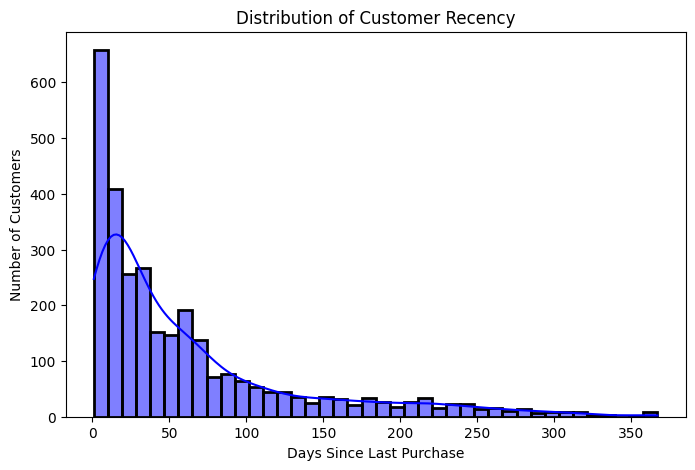

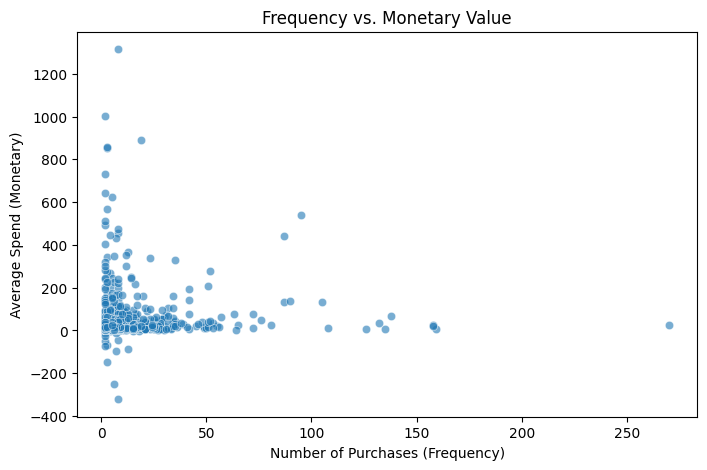

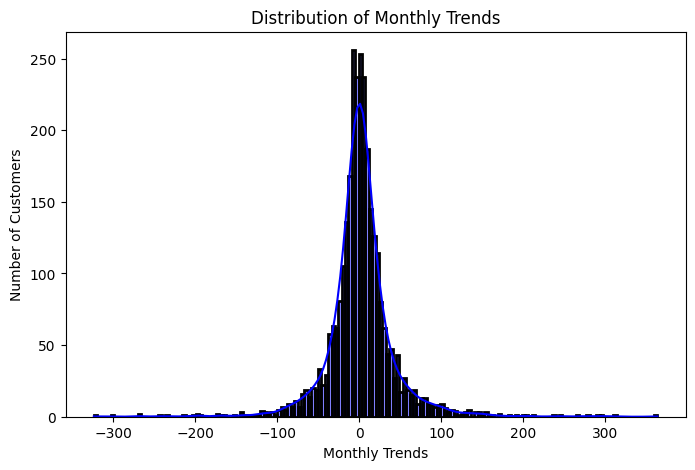

In [7]:
# Visualizations
import seaborn as sns
# 1. Distribution of Recency (How recently customers purchased)
plt.figure(figsize=(8,5))
sns.histplot(features['Recency'], color='blue', linewidth=2, kde=True)
plt.title('Distribution of Customer Recency')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Number of Customers')
plt.show()

# 2. Frequency vs. Monetary Value (Customer Segmentation)
plt.figure(figsize=(8,5))
sns.scatterplot(data=features, x='Frequency', y='Monetary', alpha=0.6)
plt.title('Frequency vs. Monetary Value')
plt.xlabel('Number of Purchases (Frequency)')
plt.ylabel('Average Spend (Monetary)')
plt.show()

# 3. Tenure Distribution (Customer Loyalty)
plt.figure(figsize=(8,5))
sns.histplot(features['MonthlyTrend'], color='blue', linewidth=2, kde=True)
plt.title('Distribution of Monthly Trends')
plt.xlabel('Monthly Trends')
plt.ylabel('Number of Customers')
plt.show()

In [8]:
features = features.reset_index(drop=True)

In [9]:
# Data Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features.drop(columns=['Churn']), features['Churn'], test_size=0.2, random_state=42)

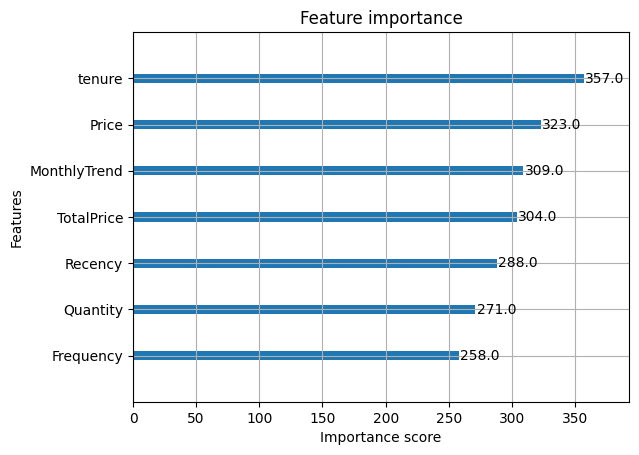

In [10]:
# Feature Selection
from xgboost import XGBClassifier
import xgboost as xgb

model = XGBClassifier(eval_metric='logloss')
model.fit(X_train,y_train)

xgb.plot_importance(model)
plt.show()

In [11]:
# RFE
from sklearn.feature_selection import RFE

rfe = RFE(model, n_features_to_select=3)
rfe.fit(X_train,y_train)

RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, device=None,
                            early_stopping_rounds=None,
                            enable_categorical=False, eval_metric='logloss',
                            feature_types=None, feature_weights=None,
                            gamma=None, grow_policy=None, importance_type=None,
                            interaction_constraints=None, learning_rate=None,
                            max_bin=None, max_cat_threshold=None,
                            max_cat_to_onehot=None, max_delta_step=None,
                            max_depth=None, max_leaves=None,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, multi_strategy=None,
                            n_estimators=None, n_jobs=None,
                            num_parallel_tree=None, ...),
    n_features_to_select=3)

In [12]:
X_train.columns

Index(['Quantity', 'Price', 'TotalPrice', 'Recency', 'Frequency', 'Monetary',
       'tenure', 'MonthlyTrend', 'AOV'],
      dtype='object')

In [13]:
idx = np.where(rfe.ranking_ == 1)[0]
selected_features = X_train.columns[idx]
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

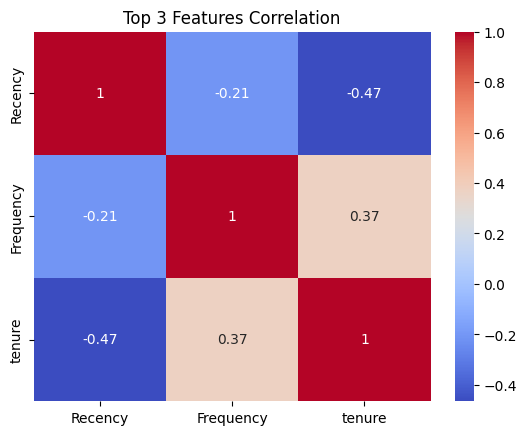

In [14]:
sns.heatmap(X_train_rfe.corr(), annot=True, cmap='coolwarm')
plt.title("Top 3 Features Correlation")
plt.show()

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train_rfe = scaler.fit_transform(X_train_rfe)
X_test_rfe = scaler.fit_transform(X_test_rfe)

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)

print(f"CV before RFE: {cross_val_score(clf,X_train, y_train,cv=5).mean()}")
print(f"CV after RFE: {cross_val_score(clf,X_train_rfe, y_train,cv=5).mean()}")

CV before RFE: 0.8683229813664596
CV after RFE: 0.8712215320910973


In [16]:
# Parameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],           # number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1],        # shrinkage rate
    'max_depth': [3, 5, 7],                    # depth of individual trees
    'min_samples_split': [2, 5, 10],           # minimum samples to split an internal node
    'min_samples_leaf': [1, 3, 5],             # minimum samples at a leaf node
    'subsample': [0.6, 0.8, 1.0],              # fraction of samples to be used for fitting the individual base learners
    'max_features': ['sqrt', 'log2', None]     # number of features to consider when looking for the best split
}

random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train_rfe, y_train)
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 5, 'learning_rate': 0.01}


In [24]:
clf_final = GradientBoostingClassifier(**random_search.best_params_)
 
clf_final.fit(X_train_rfe, y_train)
y_pred = clf_final.predict(X_test_rfe)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy on test set: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred, target_names=["Not Churned", "Churned"]))

Accuracy on test set:  0.8576158940397351
              precision    recall  f1-score   support

 Not Churned       0.90      0.84      0.87       338
     Churned       0.81      0.88      0.85       266

    accuracy                           0.86       604
   macro avg       0.86      0.86      0.86       604
weighted avg       0.86      0.86      0.86       604



Text(0.5, 1.0, 'Churn Prediction Conf Mat.')

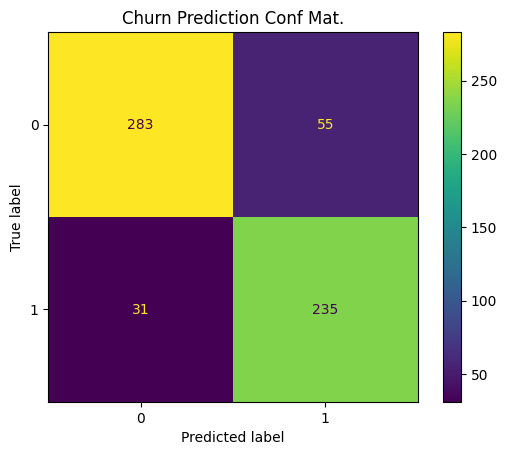

In [25]:
ConfusionMatrixDisplay(cm, display_labels=clf_final.classes_).plot()
plt.title('Churn Prediction Conf Mat.')

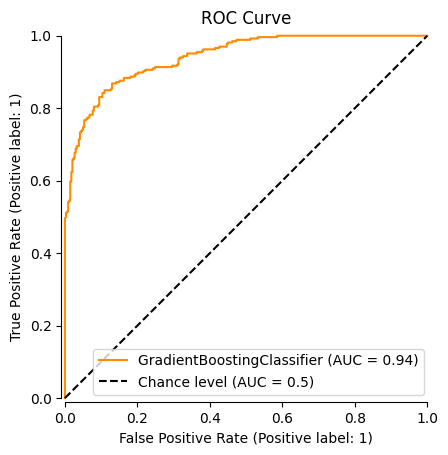

In [27]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf_final, X_test_rfe, y_test,
                               color="darkorange",
                               plot_chance_level=True,
                               despine=True)

plt.title("ROC Curve")
plt.show()

## Customer Segmentation

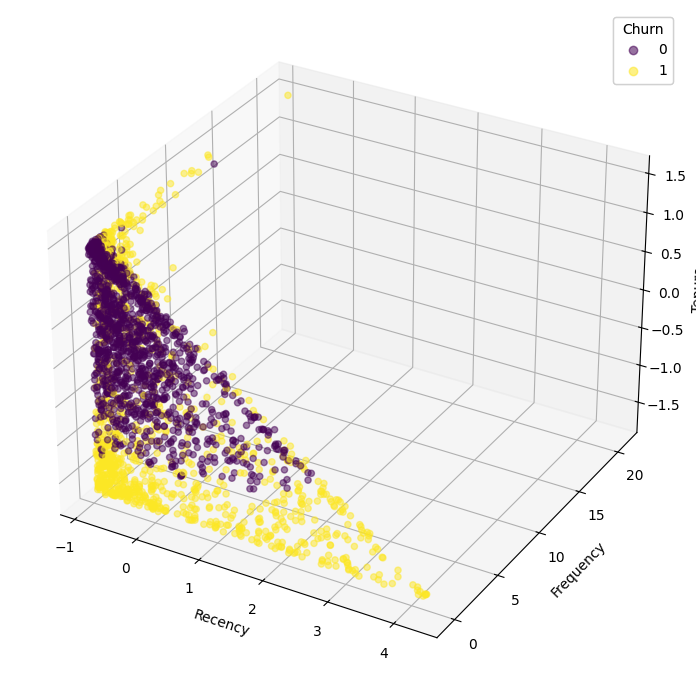

In [70]:
fig = plt.figure(figsize=(11, 7))
ax = plt.axes(projection='3d')
scatter = ax.scatter(X_train_rfe[:,0], X_train_rfe[:,1], X_train_rfe[:,2], c=y_train, alpha=0.5)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Tenure')
legend1 = ax.legend(*scatter.legend_elements(), title="Churn")
ax.add_artist(legend1)
plt.tight_layout()
plt.show()

Components: 1, AIC: 19627.58848812858, BIC: 19679.69357922336
Components: 2, AIC: 13327.216983585184, BIC: 13437.21662034083
Components: 3, AIC: 11286.477471999477, BIC: 11454.37165441599
Components: 4, AIC: 10167.482879617975, BIC: 10393.271607695355
Components: 5, AIC: 9792.353230858273, BIC: 10076.036504596519
Components: 6, AIC: 9336.679281268775, BIC: 9678.257100667888
Components: 7, AIC: 5713.344413680205, BIC: 6112.816778740186
Components: 8, AIC: 4967.71414895865, BIC: 5425.081059679497
Components: 9, AIC: 4990.882830198705, BIC: 5506.144286580419


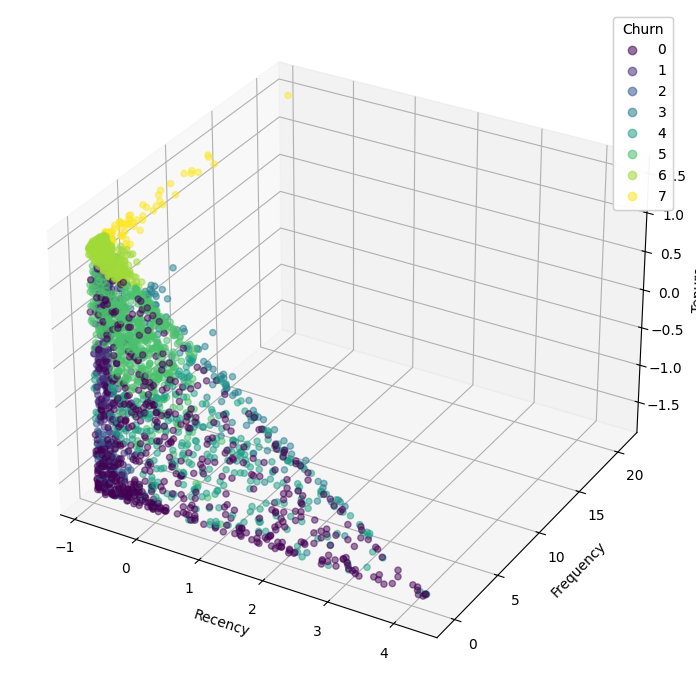

In [80]:
# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture

for n in range(1,10):
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_train_rfe)
    print(f"Components: {n}, AIC: {gmm.aic(X_train_rfe)}, BIC: {gmm.bic(X_train_rfe)}")

gmm = GaussianMixture(n_components=8, random_state=42)
gmm.fit(X_train_rfe)
y_gmm = gmm.predict(X_train_rfe)

fig = plt.figure(figsize=(11, 7))
ax = plt.axes(projection='3d')
scatter = ax.scatter(X_train_rfe[:,0], X_train_rfe[:,1], X_train_rfe[:,2], c=y_gmm, alpha=0.5)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Tenure')
legend1 = ax.legend(*scatter.legend_elements(), title="Churn")
ax.add_artist(legend1)
plt.tight_layout()
plt.show()